Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732760603.052856     117 service.cc:145] XLA service 0x7845e40018a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732760603.052919     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   2/1825 ━━━━━━━━━━━━━━━━━━━━ 2:39 88ms/step - accuracy: 0.0000e+00 - loss: 7.5879 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1732760617.855967     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1825/1825 ━━━━━━━━━━━━━━━━━━━━ 1543s 829ms/step - accuracy: 0.1976 - loss: 5.4523 - precision: 0.6927 - recall: 0.0560 - val_accuracy: 0.8550 - val_loss: 1.6326 - val_precision: 0.9407 - val_recall: 0.6980 - learning_rate: 1.0000e-04
Epoch 2/25
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 1283s 700ms/step - accuracy: 0.6352 - loss: 2.4191 - precision: 0.8740 - recall: 0.4349 - val_accuracy: 0.9120 - val_loss: 1.1456 - val_precision: 0.9565 - val_recall: 0.8680 - learning_rate: 1.0000e-04
Epoch 3/25
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 1285s 701ms/step - accuracy: 0.7410 - loss: 1.7910 - precision: 0.8952 - recall: 0.6041 - val_accuracy: 0.9385 - val_loss: 0.8927 - val_precision: 0.9624 - val_recall: 0.9075 - learning_rate: 1.0000e-04
Epoch 4/25
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 1295s 707ms/step - accuracy: 0.7797 - loss: 1.4671 - precision: 0.9061 - recall: 0.6739 - val_accuracy: 0.9525 - val_loss: 0.7076 - val_precision: 0.9718 - val_recall: 0.9290 - learning_rate: 1.0000e-04
Epoch 5/25
1825/1825 ━━━━━━━━━━

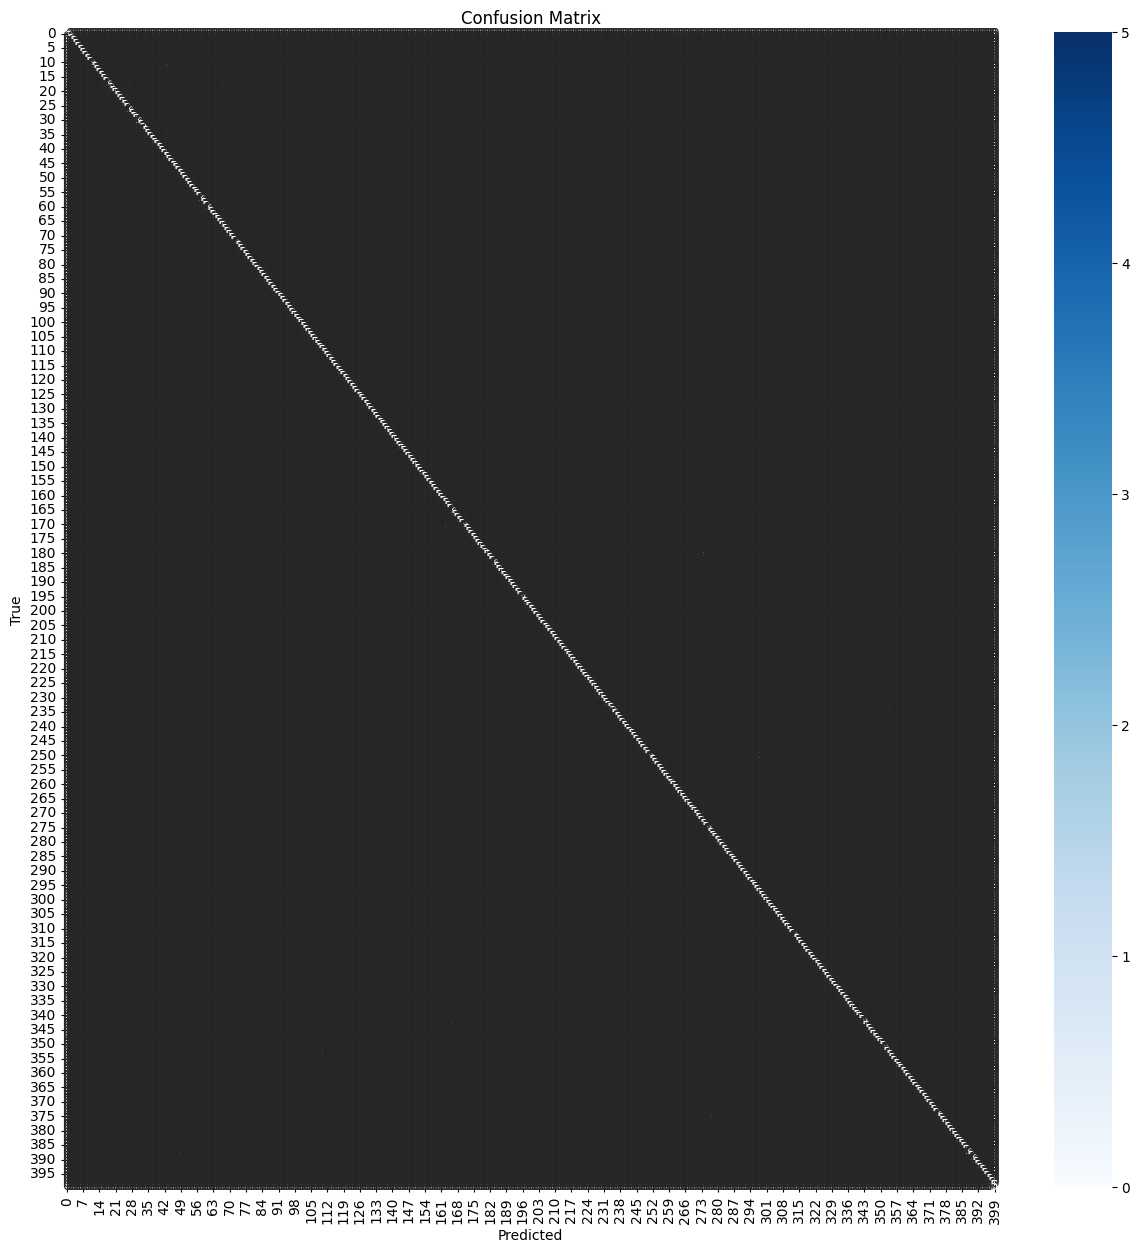

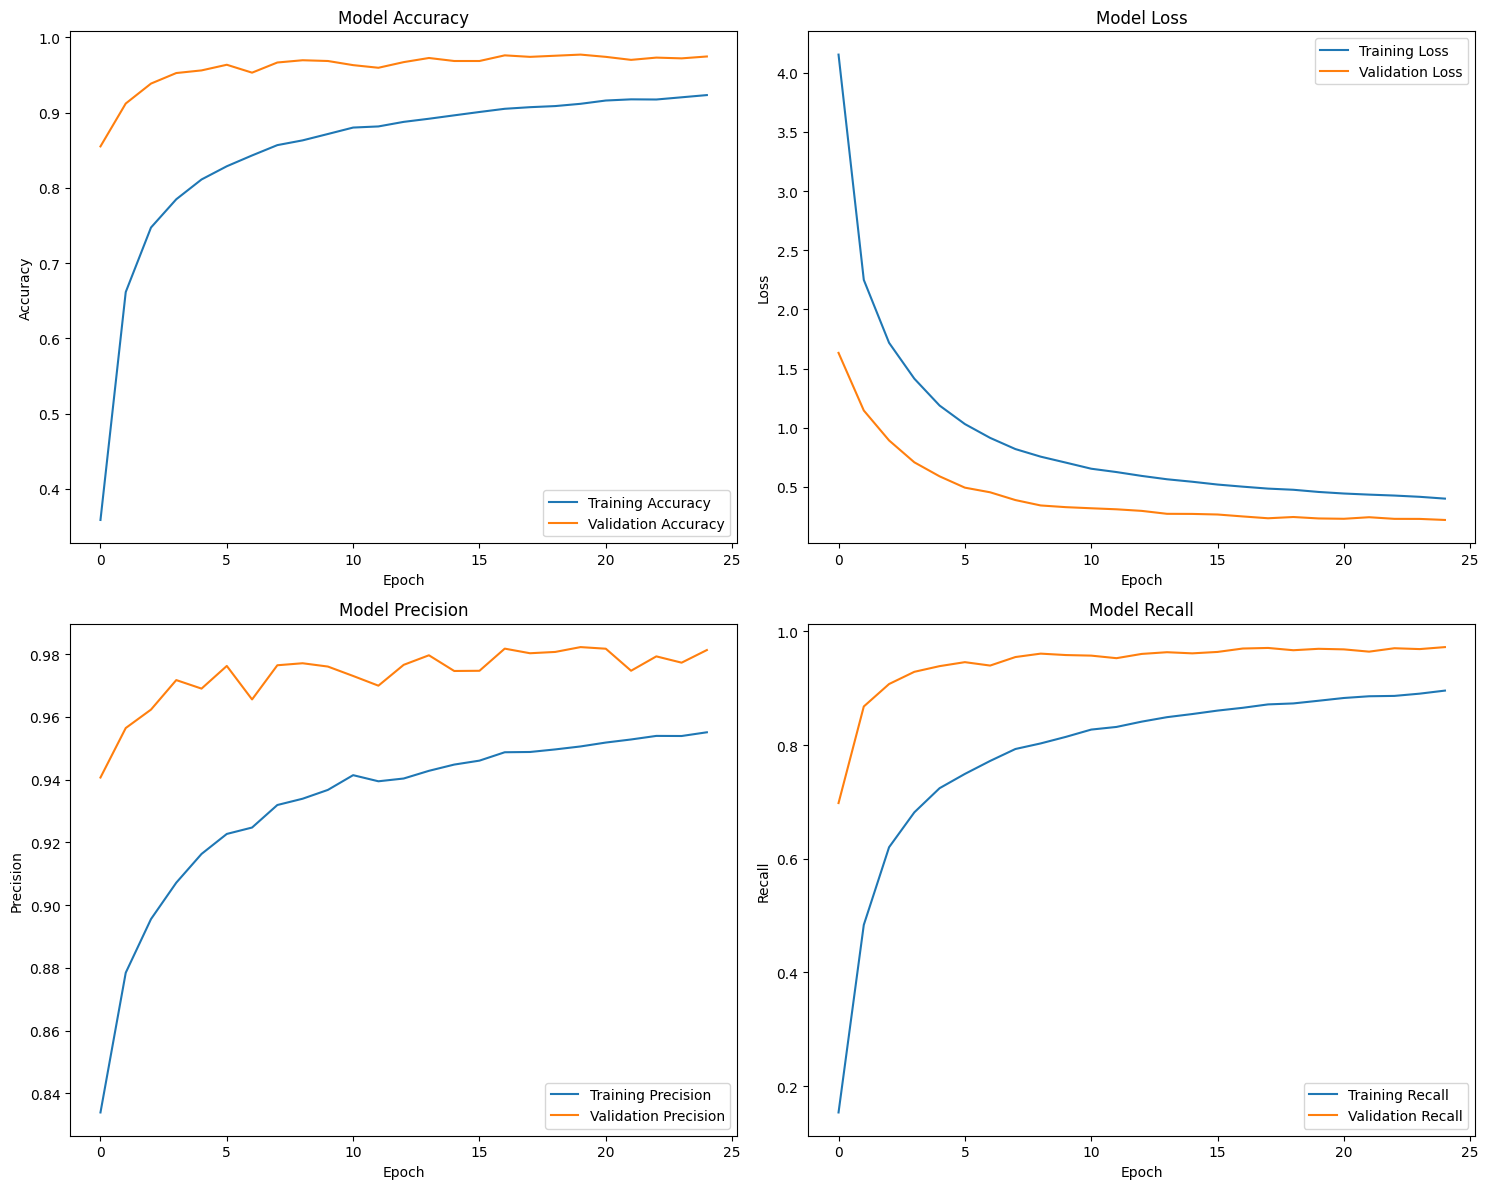

AttributeError: 'Variable' object has no attribute 'get_shape'

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support, 
                           average_precision_score, precision_recall_curve)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set paths
BASE_PATH = '/kaggle/input/400birds/400BirdSpecies'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Enhanced data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

n_classes = len(train_generator.class_indices)

# Create model
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-7
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)

# Enhanced evaluation functions
def plot_metrics(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    # Precision plot
    ax3.plot(history.history['precision'], label='Training Precision')
    ax3.plot(history.history['val_precision'], label='Validation Precision')
    ax3.set_title('Model Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    
    # Recall plot
    ax4.plot(history.history['recall'], label='Training Recall')
    ax4.plot(history.history['val_recall'], label='Validation Recall')
    ax4.set_title('Model Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

def plot_complexity_vs_performance(model, accuracy, map_score):
    trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    total_params = model.count_params()
    
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'mAP', 'Params (Millions)']
    values = [accuracy, map_score, total_params/1e6]
    
    plt.bar(metrics, values)
    plt.title('Model Complexity vs Performance')
    plt.ylabel('Score / Parameter Count')
    
    for i, v in enumerate(values):
        plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
    
    plt.show()
    
    print(f"\nModel Complexity:")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Total parameters: {total_params:,}")

def evaluate_model():
    # Get predictions and measure inference time
    start_time = time.time()
    predictions = model.predict(test_generator)
    inference_time = time.time() - start_time
    
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Convert to one-hot encoding for MAP calculation
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = np.mean(y_pred == y_true)
    map_score = average_precision_score(y_true_one_hot, predictions, average='macro')
    
    # Print metrics
    print("\nModel Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Mean Average Precision (mAP): {map_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Inference Time per Batch: {inference_time/len(test_generator):.4f} seconds")
    
    # Confusion Matrix
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot all metrics
    plot_metrics(history)
    plot_complexity_vs_performance(model, accuracy, map_score)

def show_prediction_examples(correct=True):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    mask = y_pred == y_true if correct else y_pred != y_true
    indices = np.where(mask)[0][:5]
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, idx in enumerate(indices):
        batch_idx = idx // test_generator.batch_size
        in_batch_idx = idx % test_generator.batch_size
        batch = test_generator[batch_idx]
        image = batch[0][in_batch_idx]
        
        true_class = list(test_generator.class_indices.keys())[y_true[idx]]
        pred_class = list(test_generator.class_indices.keys())[y_pred[idx]]
        
        axes[i].imshow(image)
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}')
        axes[i].axis('off')
    
    status = "Correct" if correct else "Incorrect"
    plt.suptitle(f'{status} Predictions Examples')
    plt.tight_layout()
    plt.show()

# Evaluate model and show all metrics
evaluate_model()

# Show prediction examples
print("\nCorrect Predictions:")
show_prediction_examples(correct=True)
print("\nIncorrect Predictions:")
show_prediction_examples(correct=False)

# Save model
model.save('bird_classification_model.h5')


